In [1]:
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
df = pd.read_pickle('../../../data/processed/merged/state0_new_df.pkl')
print(df.shape)

(16574, 15)


In [3]:
# eventType = 4 for turning left, eventType = 5 for turning right
# is_ios = 0 for Android, is_ios = 1 for iOS
df = df[(df['eventType'] == 4) & (df['is_ios'] == 1)]

df = df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventGPSSignalStrength', 'eventSensorDetectionMthd', 'source_file'])
df = df.dropna(subset=['bearingAngleChange'])
corr_matrix = df.corr()

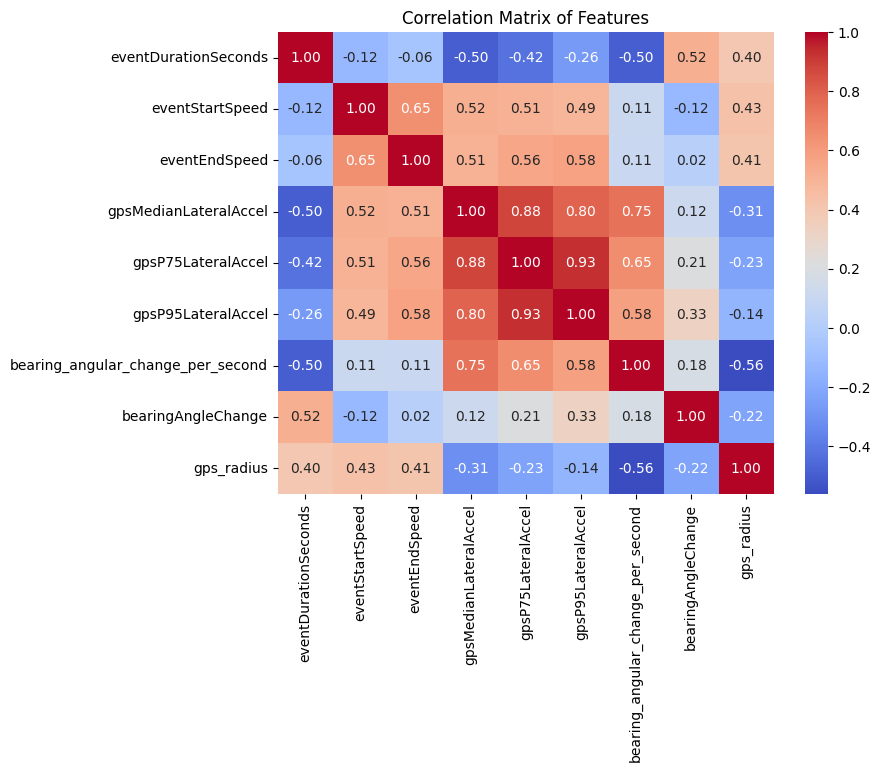

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

In [5]:
df = df.drop(columns=['gpsP75LateralAccel', 'gpsP95LateralAccel'])
corr_matrix = df.corr()

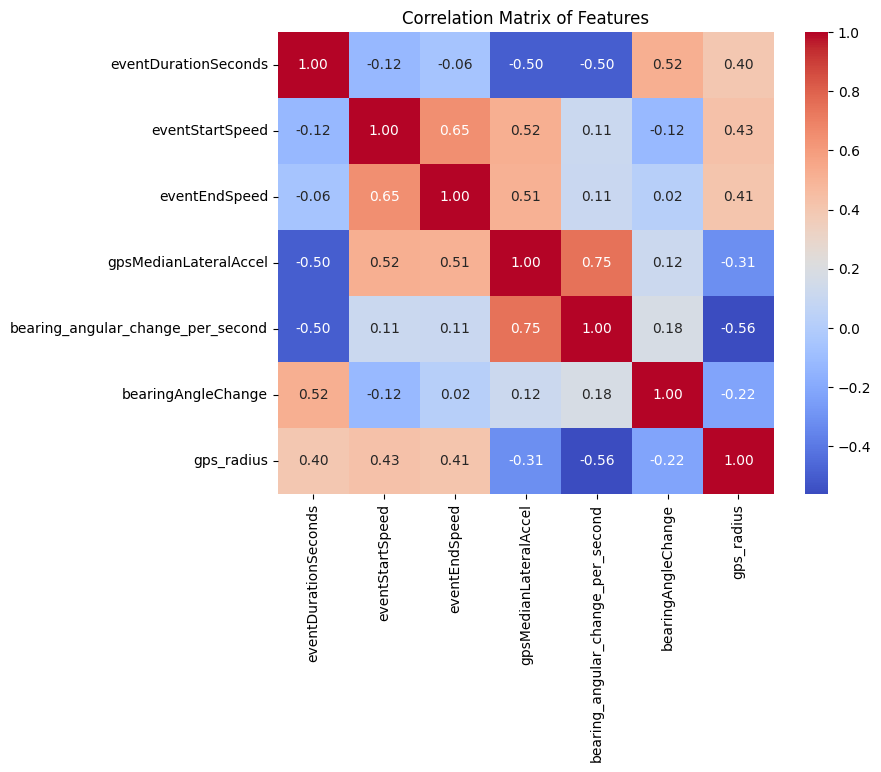

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()

In [7]:
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

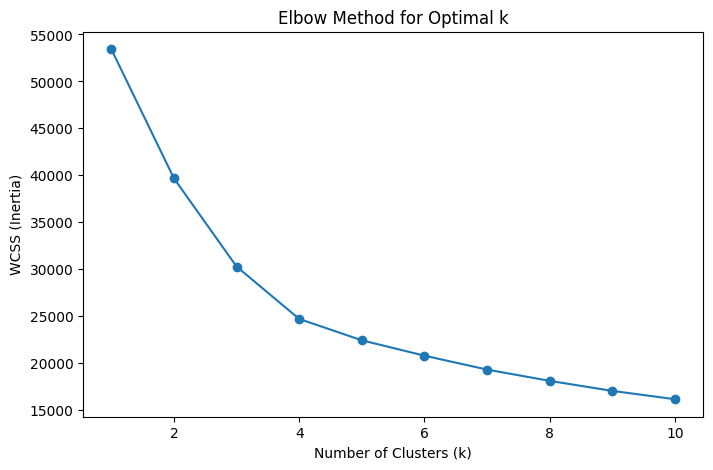

In [8]:
# Use elbow method to get optimal number of clusters
wcss = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()

,k,Silhouette Score,Calinski-Harabasz Score
0,2,0.253411,2646.018567
1,3,0.262531,2333.987940
2,4,0.305465,2957.540953
3,5,0.248519,2545.632780
4,6,0.226694,2376.510211
5,7,0.224970,2231.700967
6,8,0.218641,2081.074636
7,9,0.217212,2012.723790
8,10,0.211914,1933.625430


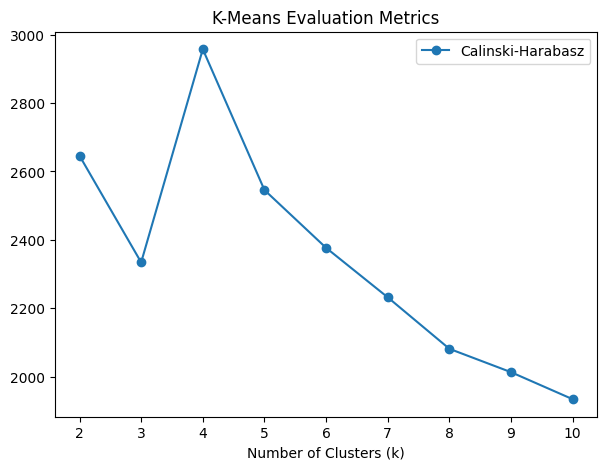

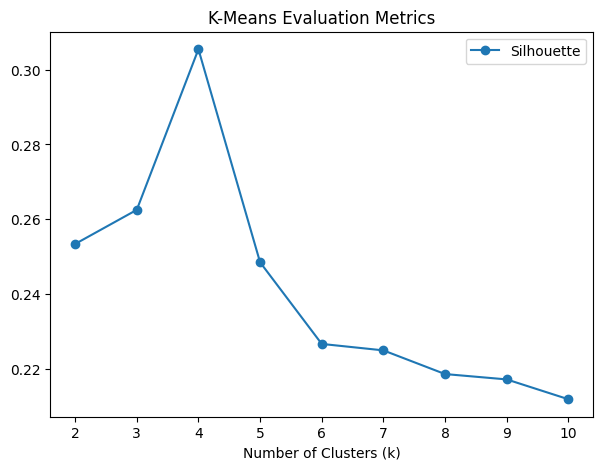

In [9]:
results = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    
    sil_score = silhouette_score(scaled_df, labels)
    ch_score = calinski_harabasz_score(scaled_df, labels)
    
    results.append({
        'k': k,
        'Silhouette Score': sil_score,
        'Calinski-Harabasz Score': ch_score
    })
    
    scaled_df_clustered = scaled_df.copy()
    scaled_df_clustered['klabel'] = labels

results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(7, 5))
plt.plot(results_df['k'], results_df['Calinski-Harabasz Score'], marker='o', label='Calinski-Harabasz')
plt.title('K-Means Evaluation Metrics')
plt.xlabel('Number of Clusters (k)')
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(results_df['k'], results_df['Silhouette Score'], marker='o', label='Silhouette')
plt.title('K-Means Evaluation Metrics')
plt.xlabel('Number of Clusters (k)')
plt.legend()
plt.show()

/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


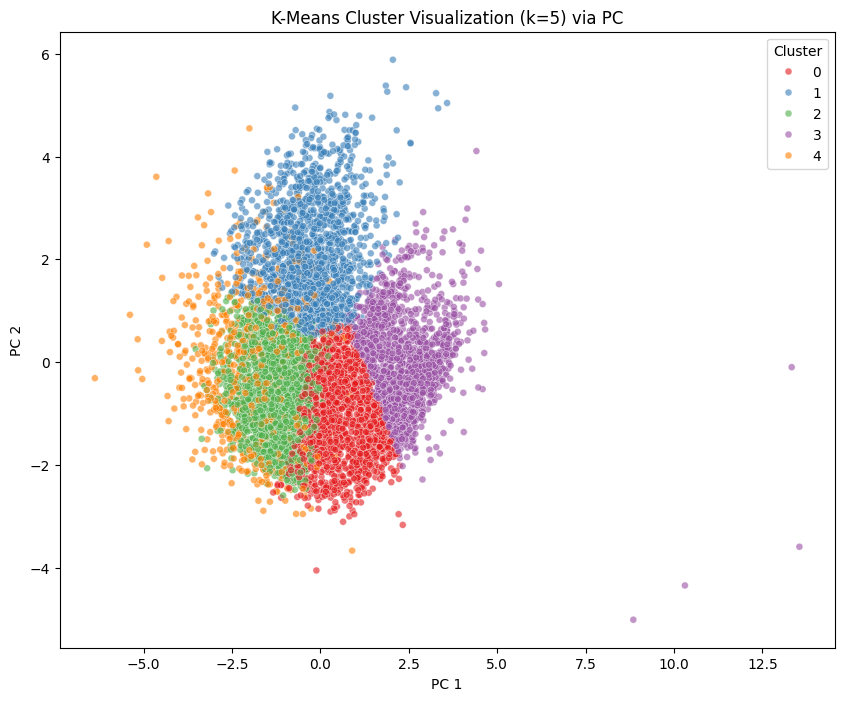

In [10]:
kmeans_final = KMeans(n_clusters=5, n_init=10)
kmeans_final.fit(scaled_df)
final_labels = kmeans_final.labels_

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster_Label'] = final_labels

cluster_centers_pca = pca.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster_Label',
    data=pca_df, 
    palette='Set1',
    alpha=0.6,
    s=25
)

plt.title('K-Means Cluster Visualization (k=5) via PC')
plt.xlabel(f'PC 1')
plt.ylabel(f'PC 2')
plt.legend(title='Cluster')
plt.show()

In [11]:
features_to_plot = [
    'eventDurationSeconds',
    'gps_radius',
    'bearingAngleChange',
    'bearing_angular_change_per_second',
    'eventStartSpeed',
    'eventEndSpeed',
    'gpsMedianLateralAccel'
]

kmeans_final = KMeans(n_clusters=5, n_init=10) 
kmeans_final.fit(scaled_df)
final_labels = kmeans_final.labels_

df_clustered = df.copy()

/var/folders/gb/z580gbzd2snggl2ym34nk9000000gn/T/ipykernel_11145/783808452.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


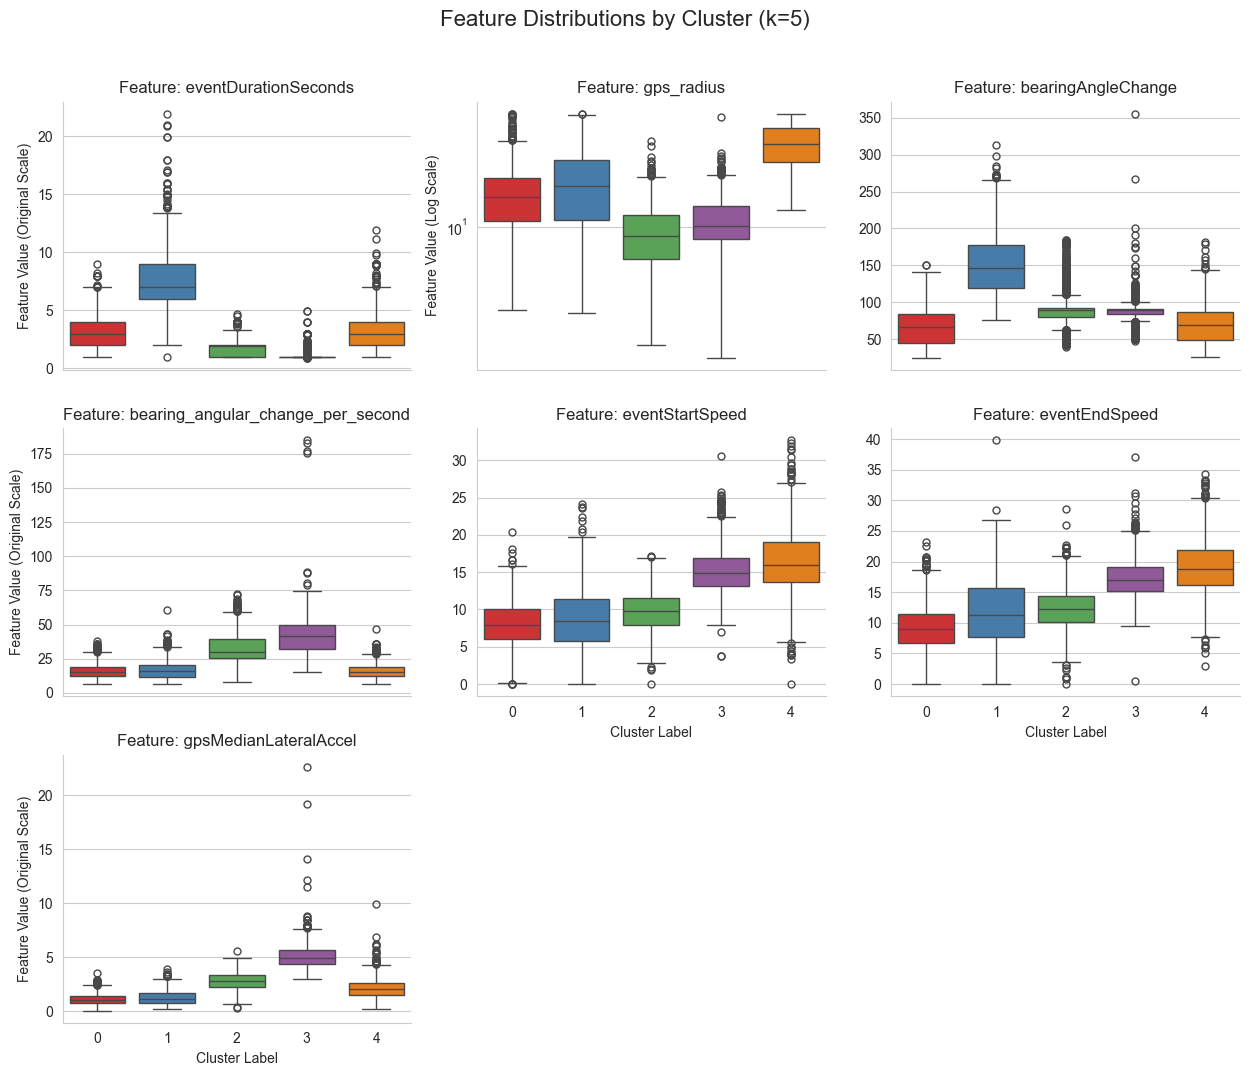

In [12]:
df_clustered['Cluster_Label'] = final_labels
df_clustered['Cluster_Label'] = df_clustered['Cluster_Label'].astype('category')

df_melted = df_clustered[['Cluster_Label'] + features_to_plot].melt(
    id_vars=['Cluster_Label'],
    var_name='Feature',
    value_name='Value'
)

sns.set_style("whitegrid")
g = sns.catplot(
    data=df_melted,
    x='Cluster_Label',
    y='Value',
    col='Feature',
    kind='box', 
    col_wrap=3, 
    palette='Set1',
    sharey=False,
    height=3.5,
    aspect=1.2  
)

g.fig.suptitle('Feature Distributions by Cluster (k=5)', y=1.02, fontsize=16)
g.set_titles("Feature: {col_name}", size=12)
g.set_axis_labels("Cluster Label", "Feature Value (Original Scale)", size=10) 
for ax in g.axes.flat:
    if 'gps_radius' in ax.get_title():
        ax.set_yscale('log')
        ax.set_ylabel("Feature Value (Log Scale)", size=10)
plt.tight_layout()
plt.show()